In [1]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./data/cleaned_train.csv')
test = pd.read_csv('./data/cleaned_test.csv')

In [3]:
final_columns = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age', ]
    #    'MRP_bin','Vis_per_Weight', 'Is_New_Outlet']       

In [4]:
train = train[final_columns].copy()
test = test[final_columns].copy()

# Preserve original IDs for submission
test_original_ids = test[['Item_Identifier', 'Outlet_Identifier']].copy()

cat_params = {
    'loss_function': 'RMSE',
    'depth': 8,               
    'l2_leaf_reg': 2.0,      
    'learning_rate': 0.05,
    'iterations': 5000,
    'early_stopping_rounds': 300,
    'bagging_temperature': 0.5  # less randomness (closer to strong learner)
}

# Train AutoGluon
predictor = TabularPredictor(
    label='Item_Outlet_Sales',
    problem_type='regression',
    eval_metric='root_mean_squared_error'
    # eval_metric='mean_absolute_error'
).fit(
    train_data=train,
    # presets='best_quality', 
    presets='high_quality',
    time_limit=600,
    save_bag_folds=True, 
    hyperparameters = {
    'RF': {},      # Random Forest
    'GBM': {},     # LightGBM
    'XGB': {},     # XGBoost
    'CAT': {},     # CatBoost
    # 'CAT': cat_params,     # CatBoost
    'KNN': {},     # KNeighborsDist
    'LR': {},      # Linear Regression
    'XT': {},      # ExtraTrees (use as Decision Tree alternative)
    # 'NN_TORCH': {}
    },
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250816_152405"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:40 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6041
CPU Count:          12
Memory Avail:       8.63 GB / 24.00 GB (35.9%)
Disk Space Avail:   284.07 GB / 460.43 GB (61.7%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	9.23s	= Expected runtime (1.85s per shuffle set)
	3.0s	= Actual runtime (Completed 5 of 5 shuffle sets)


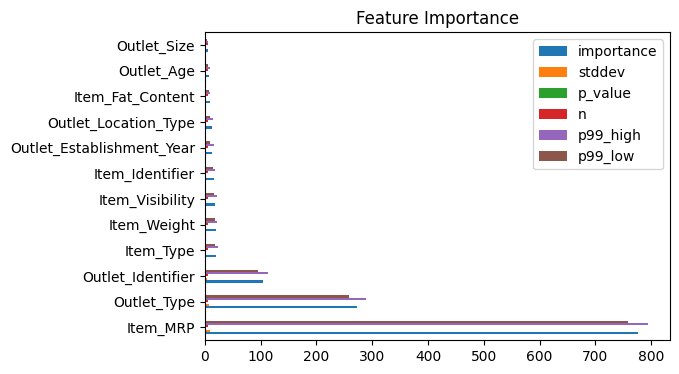

In [5]:
# Feature Importance
feat_imp = predictor.feature_importance(train)
feat_imp.plot(kind='barh', figsize=(6,4))
plt.title("Feature Importance")
plt.show()

In [6]:
# Check predictions for individual models
model_names = predictor._trainer.get_model_names()
model_preds = {}

for model in model_names:
    print(f"Predicting with model: {model}")
    try:
        model_preds[model] = predictor.predict(test, model=model)
    except Exception as e:
        print(f"Prediction failed for model {model}: {e}")

Predicting with model: KNeighbors_BAG_L1
Predicting with model: LightGBM_BAG_L1
Predicting with model: RandomForest_BAG_L1
Predicting with model: CatBoost_BAG_L1
Predicting with model: ExtraTrees_BAG_L1
Predicting with model: XGBoost_BAG_L1
Predicting with model: LinearModel_BAG_L1
Predicting with model: WeightedEnsemble_L2
Predicting with model: KNeighbors_BAG_L1_FULL
Predicting with model: LightGBM_BAG_L1_FULL
Predicting with model: RandomForest_BAG_L1_FULL
Predicting with model: CatBoost_BAG_L1_FULL
Predicting with model: ExtraTrees_BAG_L1_FULL
Predicting with model: XGBoost_BAG_L1_FULL
Predicting with model: LinearModel_BAG_L1_FULL
Predicting with model: WeightedEnsemble_L2_FULL


In [7]:
model_preds

{'KNeighbors_BAG_L1': 0       1305.900146
 1       1512.830811
 2       2319.647217
 3       1700.586304
 4       4142.075195
            ...     
 5676     939.044312
 5677    2378.104492
 5678    1172.473755
 5679    4576.842285
 5680    1792.466797
 Name: Item_Outlet_Sales, Length: 5681, dtype: float32,
 'LightGBM_BAG_L1': 0       1713.295410
 1       1394.515015
 2        594.186157
 3       2482.870605
 4       6173.729980
            ...     
 5676    2244.193115
 5677    2567.203369
 5678    1798.934448
 5679    3611.658447
 5680    1296.654419
 Name: Item_Outlet_Sales, Length: 5681, dtype: float32,
 'RandomForest_BAG_L1': 0       1608.217651
 1       1340.255371
 2        708.590942
 3       2447.593994
 4       6337.204102
            ...     
 5676    2410.635498
 5677    2773.099121
 5678    1940.205566
 5679    3678.473877
 5680    1450.458618
 Name: Item_Outlet_Sales, Length: 5681, dtype: float32,
 'CatBoost_BAG_L1': 0       1688.705566
 1       1444.375000
 2        617.6

In [8]:
# Make predictions
test_pred = predictor.predict(test).clip(lower=0)

In [9]:
# Predict & Submission
test_pred = predictor.predict(test).clip(lower=0)

submission = pd.DataFrame({
    'Item_Identifier': test_original_ids['Item_Identifier'].values,
    'Outlet_Identifier': test_original_ids['Outlet_Identifier'].values,
    'Item_Outlet_Sales': test_pred.values 
    # 'Item_Outlet_Sales': np.square(test_pred.values) # Scale back to original range
})

submission.to_csv('submission.csv', index=False)

In [10]:
# TODO: 
# Ensemble Weights: {'CatBoost_BAG_L1': 0.783, 'LightGBM_BAG_L1': 0.087, 'XGBoost_BAG_L1': 0.087, 'ExtraTrees_BAG_L1': 0.043} 
# According to the selected Ensemble model, CatBoost is the best model
# However upon multiple submissions, observed that CatBoost is underforecasting the sales
# Few things to try:
# 1. Try different hyperparameters for CatBoost
# 2. Try target variable transformations to square root just for CatBoost
# 3. Missing drivers of spikes (promos/season/holiday/price changes), adding more categorical features
# 4. Evaluation choice: optimizing RMSE can still prefer slight underprediction if extremes are rare, can consider tweedie loss
# 5. Hyperparameter tuning for CatBoost